Customer Segmentation using Clustering Methods

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [2]:
df = pd.read_csv('Online_retail_data.csv')

In [3]:
df.head()

,Invoice,Description,Quantity,InvoiceDate,Price,Customer ID
0,INV1,Product D,12,2023-01-01 00:00:00,63.86,C56
1,INV2,Product E,12,2023-01-01 01:00:00,75.73,C76
2,INV3,Product C,4,2023-01-01 02:00:00,17.88,C51
3,INV4,Product E,16,2023-01-01 03:00:00,41.54,C37
4,INV5,Product E,4,2023-01-01 04:00:00,42.85,C17


In [4]:
df.isnull().sum()

Invoice        0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.describe()

,Quantity,Price
count,1000.000000,1000.000000
mean,9.977000,49.881190
std,5.470868,28.834394
min,1.000000,1.020000
25%,5.000000,24.027500
50%,10.000000,50.080000
75%,15.000000,75.097500
max,19.000000,99.970000


In [7]:
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

df.describe()

,Quantity,Price
count,1000.000000,1000.000000
mean,9.977000,49.881190
std,5.470868,28.834394
min,1.000000,1.020000
25%,5.000000,24.027500
50%,10.000000,50.080000
75%,15.000000,75.097500
max,19.000000,99.970000


In [8]:
df['TotalPrice'] = df['Quantity'] * df['Price']

In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

current_date = df['InvoiceDate'].max()

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate' : lambda x: (current_date - x.max()).days,
    'Invoice' : 'count',
    'TotalPrice' : 'sum'
}).reset_index()

rfm.columns = ['CoustomerID', 'Recency', 'Frequency', 'Monetary']

rfm = rfm[rfm['Monetary'] > 0]

In [10]:
rfm.head()

,CoustomerID,Recency,Frequency,Monetary
0,C1,1,9,6319.24
1,C10,2,14,8097.72
2,C100,11,13,5465.74
3,C11,2,8,4313.14
4,C12,5,6,4148.32


In [11]:
rfm['Recency_log'] = np.log(rfm['Recency'] + 1)
rfm['Frequency_log'] = np.log(rfm['Frequency'])
rfm['Monetary_log'] = np.log(rfm['Monetary'])

rfm_features = rfm[['Recency_log', 'Frequency_log', 'Monetary_log']]

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

In [12]:
rfm_scaled_df.head()

,Recency,Frequency,Monetary
0,-0.617361,-0.163701,0.691310
1,-0.126774,1.162297,1.223677
2,1.550553,0.939889,0.379813
3,-0.126774,-0.517184,-0.128617
4,0.711889,-1.380555,-0.212262


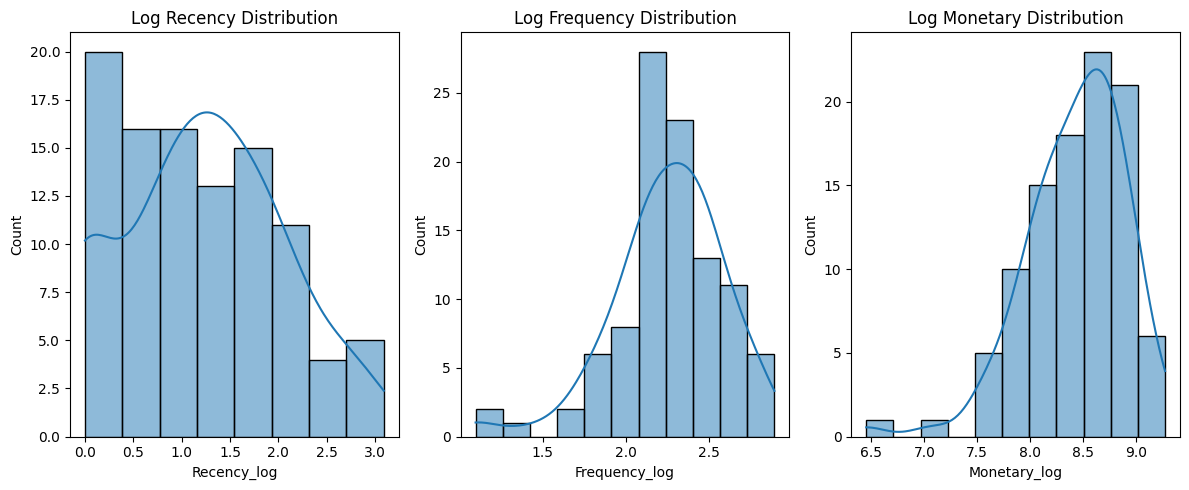

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency_log'], kde=True)
plt.title('Log Recency Distribution')

plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency_log'], kde=True)
plt.title('Log Frequency Distribution')

plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary_log'], kde=True)
plt.title('Log Monetary Distribution')

plt.tight_layout()

Text(0, 0.5, 'Within-Cluster Sum of Squares (WCSS)')

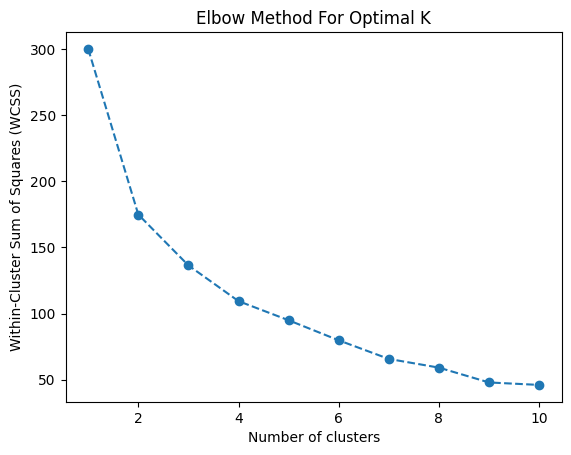

In [14]:
wcss = []

for K in range(1, 11):
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')


In [15]:
optimal_k = 2

kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_optimal.fit(rfm_scaled_df)

rfm['KMeans_Cluster'] = kmeans_optimal.labels_

rfm.head()

,CoustomerID,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log,KMeans_Cluster
0,C1,1,9,6319.24,0.693147,2.197225,8.751354,0
1,C10,2,14,8097.72,1.098612,2.639057,8.999338,0
2,C100,11,13,5465.74,2.484907,2.564949,8.606255,0
3,C11,2,8,4313.14,1.098612,2.079442,8.369421,1
4,C12,5,6,4148.32,1.791759,1.791759,8.330459,1


In [16]:
kmeans_silhouette = silhouette_score(rfm_scaled_df, rfm['KMeans_Cluster'])
print(f'K-Means Silhouette Score: {kmeans_silhouette:.4f}')

K-Means Silhouette Score: 0.3625


Text(0.5, 1.0, 'K-Means Clustering Results')

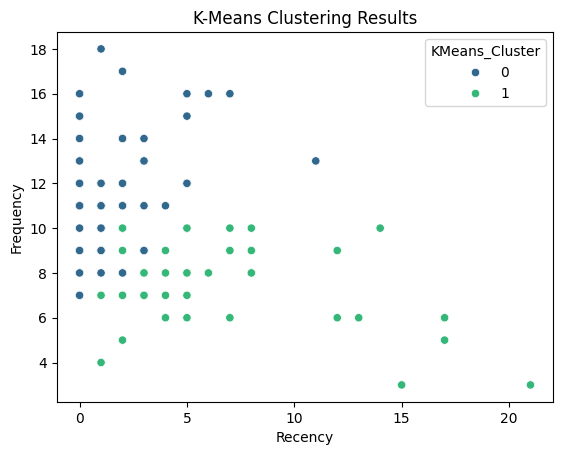

In [17]:
sns.scatterplot(x=rfm['Recency'], y=rfm['Frequency'], hue=rfm['KMeans_Cluster'], palette='viridis')
plt.title('K-Means Clustering Results')

Hierrchical Clustering

Text(0.5, 1.0, 'Hierarchical Clustering Dendrogram')

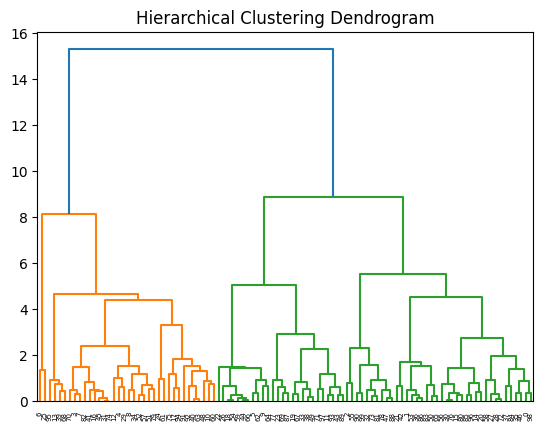

In [18]:
Z = linkage(rfm_scaled_df, method='ward')
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')

In [19]:
rfm['Hierarchical_Cluster'] = fcluster(Z, t=2, criterion='maxclust')

In [20]:
hierarchical_silhouette = silhouette_score(rfm_scaled_df, rfm['Hierarchical_Cluster'])
print(f'Hierarchical Clustering Silhouette Score: {hierarchical_silhouette:.4f}')

Hierarchical Clustering Silhouette Score: 0.3416


Text(0.5, 1.0, 'Hierarchial Clustering of Customers')

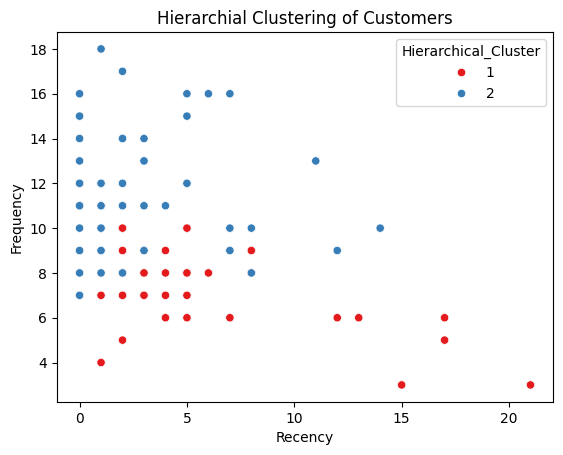

In [21]:
sns.scatterplot(x=rfm['Recency'], y=rfm['Frequency'], hue=rfm['Hierarchical_Cluster'], palette='Set1')
plt.title('Hierarchial Clustering of Customers')

DBSCAN

In [22]:
dbscan = DBSCAN(eps=0.5, min_samples=6)
rfm['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_scaled_df)

In [23]:
print('DBSCAN Cluster labels :', set(rfm['DBSCAN_Cluster']))

DBSCAN Cluster labels : {0, 1, 2, -1}


In [24]:
dbscan_silhouette = silhouette_score(rfm_scaled_df[rfm['DBSCAN_Cluster'] != -1], rfm['DBSCAN_Cluster'][rfm['DBSCAN_Cluster'] != -1])
print(f'DBSCAN Silhouette Score: {dbscan_silhouette:.4f}')

DBSCAN Silhouette Score: 0.6829


Text(0.5, 1.0, 'DBSCAN Clustering of Customers')

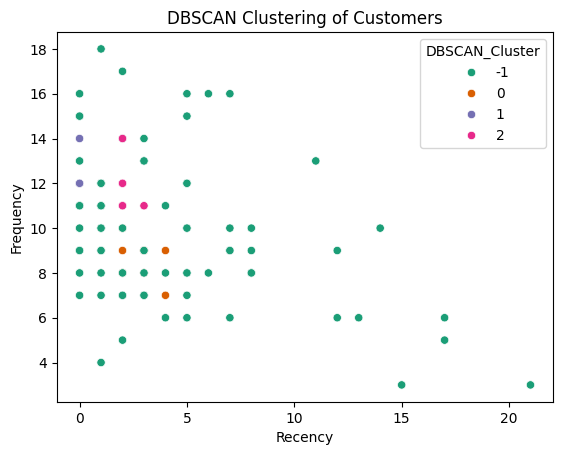

In [25]:
sns.scatterplot(x=rfm['Recency'], y=rfm['Frequency'], hue=rfm['DBSCAN_Cluster'], palette='Dark2')
plt.title('DBSCAN Clustering of Customers')

Mean-Shift Clustering

In [26]:
mean_shift = MeanShift(bandwidth=0.5)
rfm['MeanShift_Cluster'] = mean_shift.fit_predict(rfm_scaled_df)

In [27]:
if len(set(rfm['MeanShift_Cluster'])) > 1:
    mean_shift_silhouette = silhouette_score(rfm_scaled_df, rfm['MeanShift_Cluster'])
    print(f'Mean-Shift Silhouette Score: {mean_shift_silhouette:.4f}')
else:
    print('Mean-Shift resulted in a single cluster, silhouette score is not defined.')

Mean-Shift Silhouette Score: 0.2751


Text(0.5, 1.0, 'Mean-Shift Clustering of Customers')

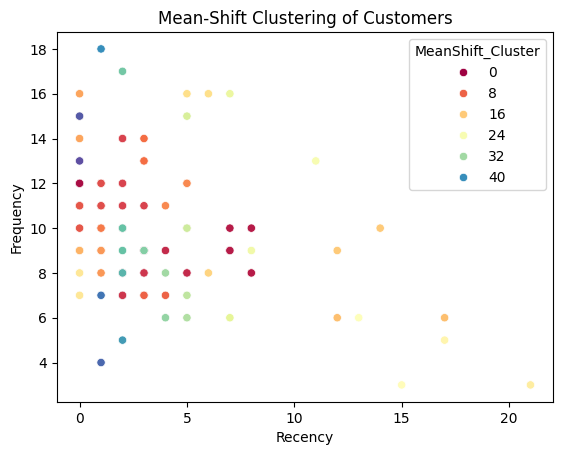

In [28]:
sns.scatterplot(x=rfm['Recency'], y=rfm['Frequency'], hue=rfm['MeanShift_Cluster'], palette='Spectral')
plt.title('Mean-Shift Clustering of Customers')

Gaussian Mixture Model

In [29]:
gmm = GaussianMixture(n_components=2, random_state=42)
rfm['GMM_Cluster'] = gmm.fit_predict(rfm_scaled_df)

In [30]:
gmm_shilhouette = silhouette_score(rfm_scaled_df, rfm['GMM_Cluster'])
print(f'GMM Silhouette Score: {gmm_shilhouette:.4f}')

GMM Silhouette Score: 0.1601


Text(0.5, 1.0, 'GMM Clustering of Customers')

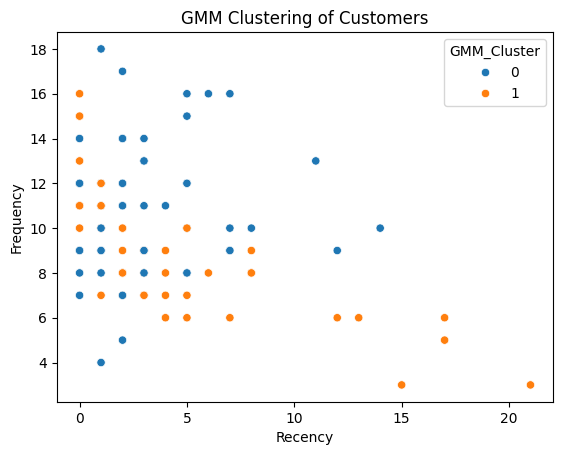

In [31]:
sns.scatterplot(x=rfm['Recency'], y=rfm['Frequency'], hue=rfm['GMM_Cluster'], palette='tab10')
plt.title('GMM Clustering of Customers')

In [32]:
print(f"K-Means Silhouette Score: {kmeans_silhouette}")
# print(f"K-Medoids Silhouette Score: {}")
print(f"Hierarchical Silhouette Score: {hierarchical_silhouette}")
print(f"DBSCAN Silhouette Score (excluding noise): {dbscan_silhouette}")
print(f"Mean-Shift Silhouette Score: {mean_shift_silhouette}")
print(f"GMM Silhouette Score: {gmm_shilhouette}")

K-Means Silhouette Score: 0.3625081959919717
Hierarchical Silhouette Score: 0.3416192286034576
DBSCAN Silhouette Score (excluding noise): 0.6829250993998572
Mean-Shift Silhouette Score: 0.2751143752499596
GMM Silhouette Score: 0.1601147956766518


In [33]:
rfm.head()

,CoustomerID,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log,KMeans_Cluster,Hierarchical_Cluster,DBSCAN_Cluster,MeanShift_Cluster,GMM_Cluster
0,C1,1,9,6319.24,0.693147,2.197225,8.751354,0,2,-1,12,0
1,C10,2,14,8097.72,1.098612,2.639057,8.999338,0,2,-1,9,0
2,C100,11,13,5465.74,2.484907,2.564949,8.606255,0,2,-1,24,0
3,C11,2,8,4313.14,1.098612,2.079442,8.369421,1,1,-1,4,0
4,C12,5,6,4148.32,1.791759,1.791759,8.330459,1,1,-1,31,1
